In [1]:
import os
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datetime import datetime

from tqdm import tqdm
import json

from sklearn.preprocessing import normalize

In [2]:
from code import model
from code.data import Dataset
from code import epoch
from code import evaluation

In [3]:
root = os.getcwd()
batch = 8
forecast = 30
samples = 5
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# date_time = datetime.strftime(datetime.now(), "%Y-%m-%d_%H-%M")
date_time = "2021-04-09_14-39"

# Model

In [4]:
def load_checkpoint(filepath, device):

    encoder = model.Extractor(in_channels=1, out_channels=1)
    decoder = model.Decoder(classes=forecast) # forcast 30 days

    predictor = model.Model(encoder=encoder, decoder=decoder).to(device)
    
        
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath)
        predictor.load_state_dict(checkpoint['model_stat'])
        optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_stat'])
        
        print("Find pretrain.")

    else:
        optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-4)
        
        print("New model and optimizer")
        
    return predictor, optimizer

In [5]:
dataset = Dataset(path=os.path.join(root, "training.csv"))

In [6]:
predictor, optimizer = load_checkpoint(
                        filepath=os.path.join(root, "results", date_time, "{}.pth".format(date_time)),
                        device=device)

Find pretrain.


In [7]:
trainloader = DataLoader(dataset, batch_size=batch, shuffle=False, num_workers=2)

In [8]:
train_info = {
       "kendal": []
}

kendal_min = 1
for e in range(5000):
    
    train_loss = epoch.train_epoch(predictor, optimizer, trainloader, device)
    pr, gt = epoch.test_epoch(predictor, dataset, device)
    
    kendal = evaluation.normalised_kendall_tau_distance(gt, pr)
    train_info["kendal"].append(kendal)
    
    print("Epoch: {}, loss = {:.5f}, kendal = {:.5f}".format(e+1, train_loss, kendal))
    
    if kendal < kendal_min:
        checkpoint = {
            'model_stat': predictor.state_dict(),
            'optimizer_stat': optimizer.state_dict(),
        }

        torch.save(checkpoint, os.path.join(root, "results", date_time, "{}.pth".format(date_time)))
        kendal_min = kendal
    with open(os.path.join(root, "results", date_time, "{}.json".format(date_time)), 'w') as f:
        json.dump(train_info, f)

35it [00:03,  9.90it/s]


KeyboardInterrupt: 

In [8]:
date_time

'2021-04-09_14-39'

In [9]:
predict, truth = epoch.test_epoch(predictor, dataset, device)

1158it [00:22, 50.90it/s]


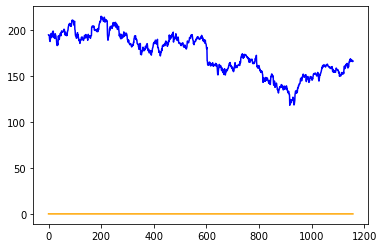

In [10]:
plt.plot(truth, 'b')
plt.plot(predict, 'orange')
plt.savefig(os.path.join(root, "results", date_time, "origin.png"))
plt.show()

In [11]:
predict = np.reshape(predict, (1, -1))
predict = np.squeeze(normalize(np.array(predict)))
truth = np.reshape(truth, (1, -1))
truth = np.squeeze(normalize(np.array(truth)))

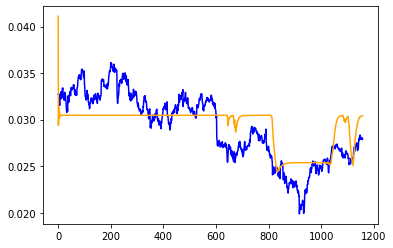

In [12]:
plt.plot(truth, 'b')
plt.plot(predict, 'orange')
plt.savefig(os.path.join(root, "results", date_time, "normalize.png"))
plt.show()